# Baseline linear regression model

### Description and details of this model can be found in the technical report

In [413]:
import numpy as np
from sklearn import linear_model
import pandas as pd
import yaml
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import os
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn.model_selection import train_test_split
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import scipy

In [414]:
ROOT_DIR = os.getcwd() + '/../'
try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
    
DATA_DIR = ROOT_DIR + config['data']['final'] + '/' + 'all_merged.csv'
data = pd.read_csv(DATA_DIR)
cities = pd.read_csv(ROOT_DIR + config['cities'])

### Cities information:

* **ALE:**	Alert, Canada
* **ABZ:**	Annaberg-Buchholz, Germany
* **ASP:**	Aspvreten, Sweden
* **BOT:**	Botsalano, South Africa
* **BSL:**	Bösel (Südoldenburg), Germany
* **EGB:**	Egbert, Canada
* **HEL:**	Helsinki, Finland
* **HPB:**	Hohenpeissenberg, Germany
* **HYY:**	Hyytiälä, Finland
* **KCE:**	Kosetice, Czech Republic
* **KPZ:**	K-Puszta, Hungary
* **MHD:**	Mace Head, Ireland
* **MAR:**	Marikana, South Africa
* **MLP:**	Melpitz, Germany
* **NAN:**	Nanjing, China
* **NEU:**	Neuglobsow, Germany
* **SAO:**	São Paulo, Brazil
* **SCH:**	Schauinsland, Germany
* **SGP:**	Southern Great Plains, Oklahoma, US
* **VIE:**	Vielsalm, Belgium
* **VAR:**	Värriö, Finland
* **WAL:**	Waldhof, Germany

In [415]:
def equation(i_and_coefs):    
    i_and_coefs = [ '%.6f' % e for e in i_and_coefs ]
    eq = """N100 = {} + {} * exp({} * T) + {} * log(CO) """
        
    return eq.format(*i_and_coefs)


def args_for_lm(data,c):
    y = data['concentration']
    t = np.exp(c * data['t'])
    lco = np.log(data['co'])
    
    X = pd.DataFrame({'t' : t, 'lco' : lco, })
    
    return X, y


def lin_model(X,y, X_test):
    lm = linear_model.LinearRegression()
    fit = lm.fit(X,y)
    pred = lm.predict(X_test)
    
    return lm, fit, pred

In [416]:
def draw_scatterplot_sns2(d, name, axs, i, r2, rmse, eq):
    y = d['log(obs)']
    pred = d['log(pred)']
    slope, intercept = np.polyfit(y, pred, 1)
    xx = np.arange(np.min(d[['log(pred)', 'log(obs)']].min(axis=1)), np.max(d[['log(pred)', 'log(obs)']].max(axis=1)) + 1,1)    

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    axs[i].text(0.05, 0.95, r2, transform=axs[i].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    axs[i].text(0.05, 0.89, rmse, transform=axs[i].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    sns.lineplot(xx,xx, color = 'red', ax = axs[i], linewidth = 0.5)
    sns.lineplot(y, slope * y + intercept, color = 'blue', linewidth = 1, ax = axs[i])
    sns.scatterplot(x = 'log(obs)', y = 'log(pred)', data = d, alpha = 0.60, ax = axs[i]).set_title(name + ' fit \n' + eq)
    
    
def draw_jointplot(d,name,axs,i):
    sns.jointplot(x="log(obs)", y="log(pred)", data=d, kind="reg")
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax = plt.gca()
    ax.text(0.05, 0.95, name, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

/Users/privatejet/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/Users/privatejet/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/Users/privatejet/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

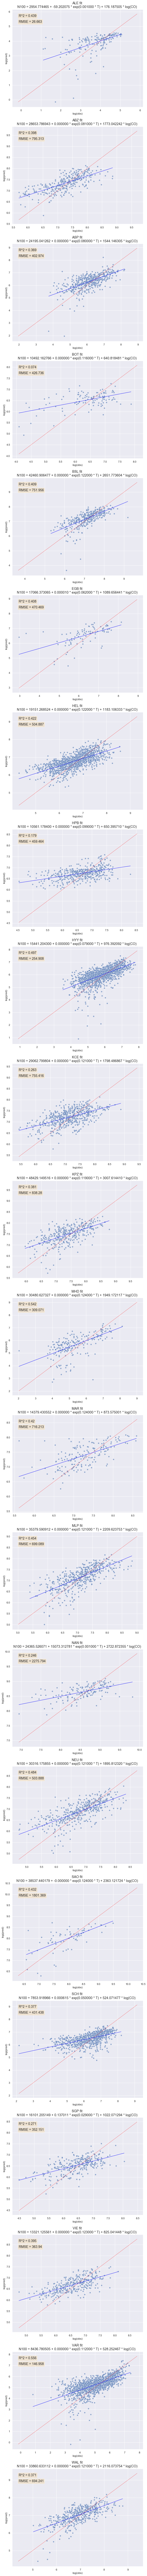

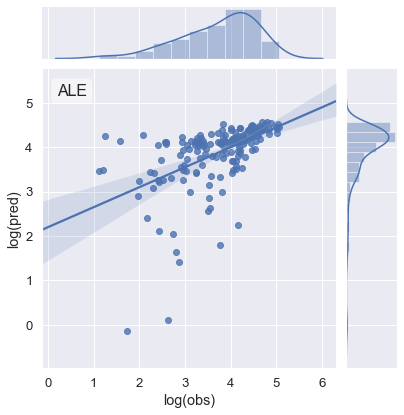

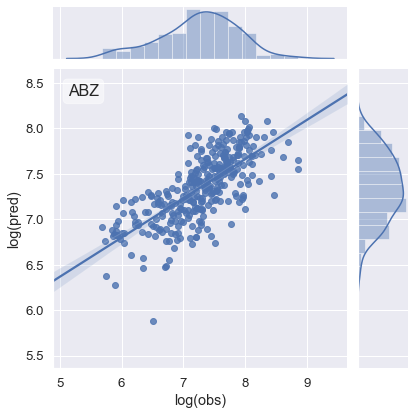

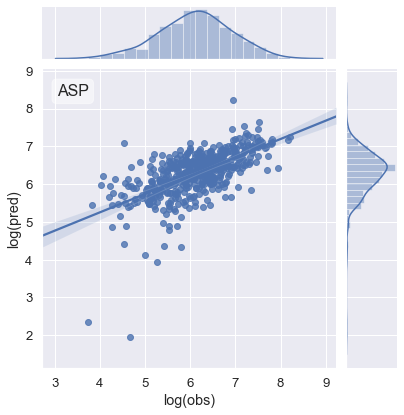

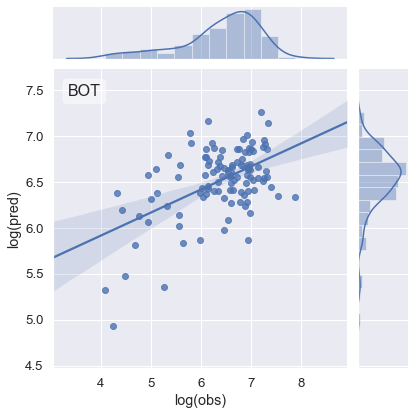

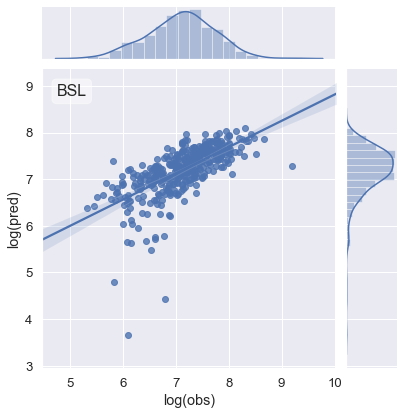

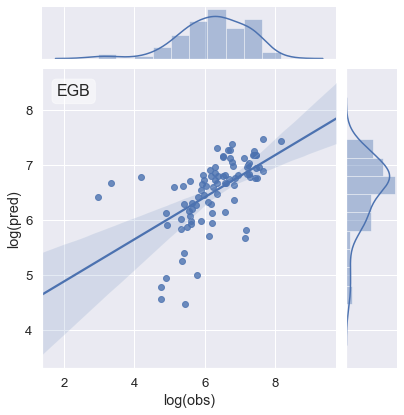

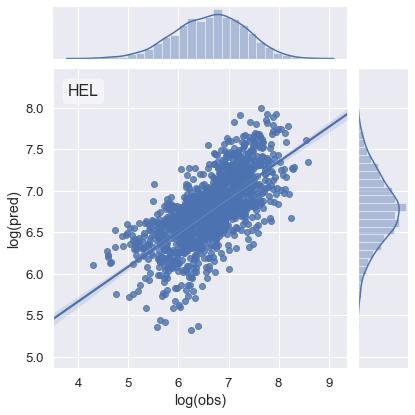

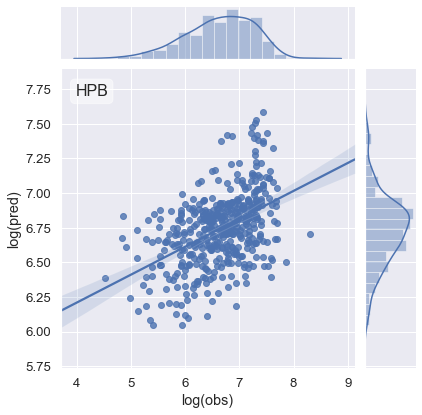

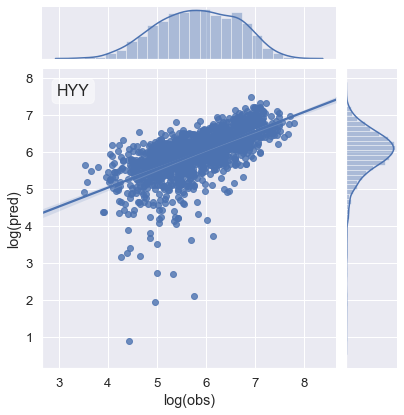

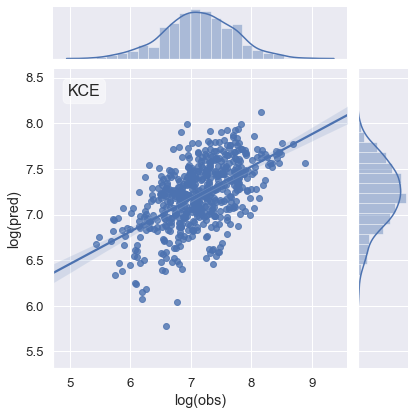

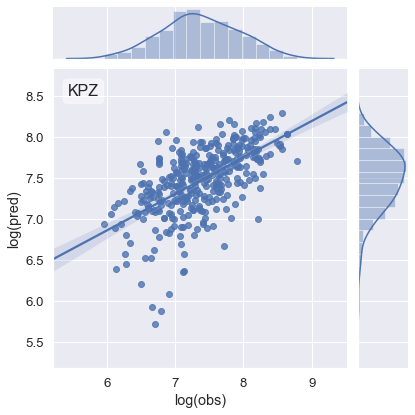

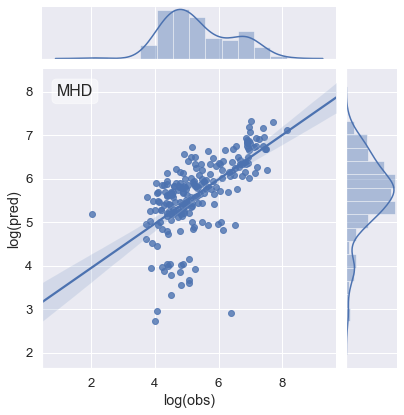

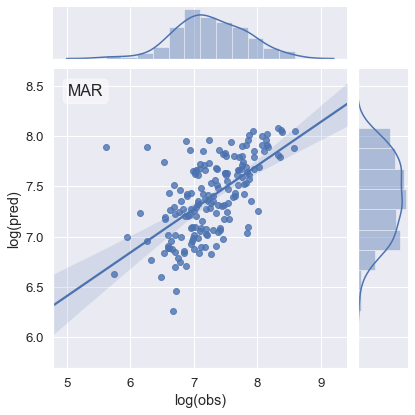

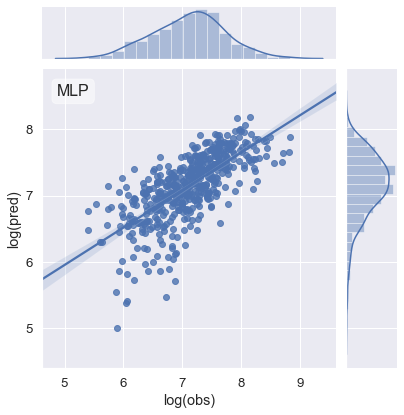

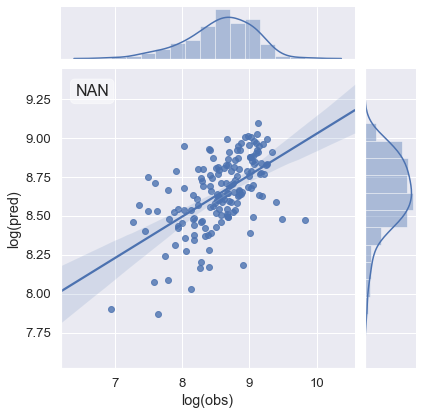

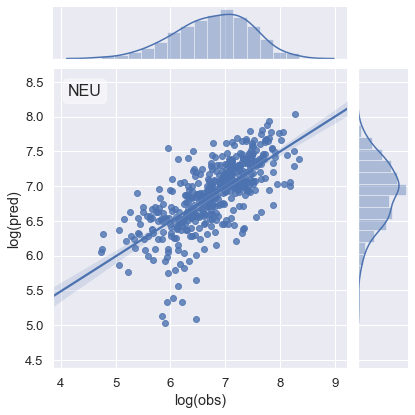

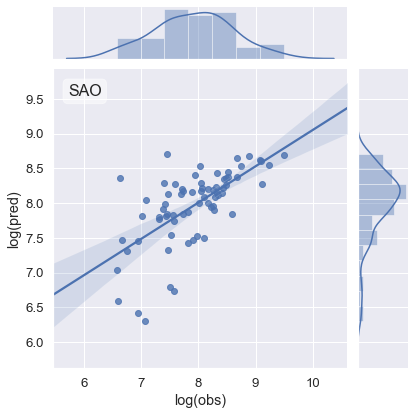

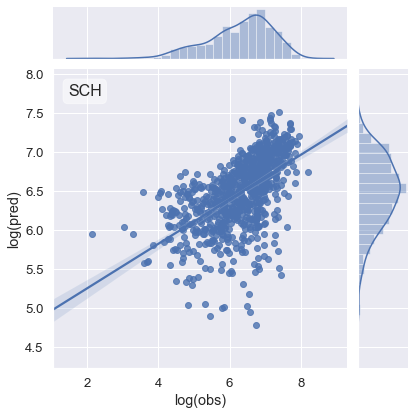

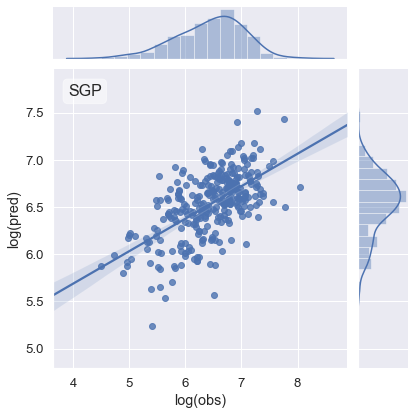

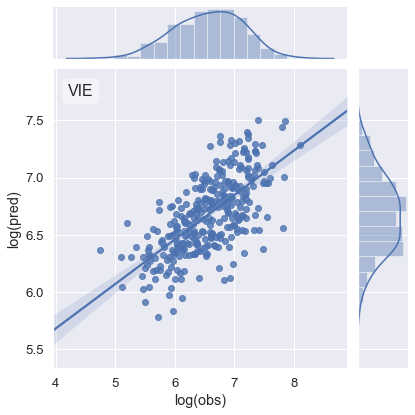

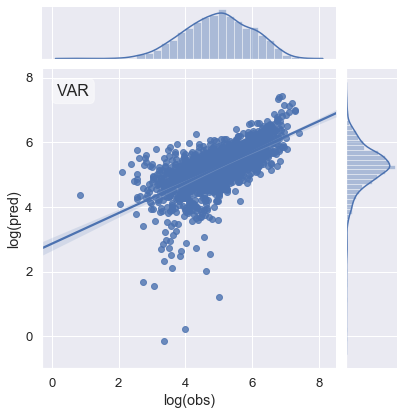

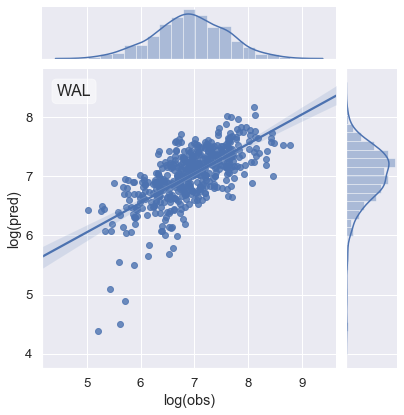

In [417]:
cities = data['city'].unique()
n = len(cities)

fig, axs = plt.subplots(n)
fig.set_size_inches(10, 200)
sns.set(font_scale=1.2)

all_coefs = {}

# fit separately for each location and draw a scatterplot
for i, loc in enumerate(cities):
    loc_data = data[data['city'] == loc]
    
    
    # search for the best constant for exp(c * T)
    cs = np.arange(0.001,0.2, 0.001)
    best_c = 1
    smallest_rmse = 100000
    
    for c in cs:
        X, y = args_for_lm(loc_data, c)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        lm, fit, pred = lin_model(X_train, y_train, X_test)
        rmse = np.sqrt(mean_squared_error(y_test,pred))
        
        if rmse < smallest_rmse:
            smallest_rmse = rmse
            best_c = c
        
    # fit with the 'best' c
    X, y = args_for_lm(loc_data, best_c)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    lm, fit, pred = lin_model(X_train, y_train, X_test)

    coefs = np.insert(lm.coef_, 0, lm.intercept_)
    coefs = np.insert(coefs, 2, best_c)
    all_coefs[loc] = coefs
    
    eq = equation(coefs)
    rmse = np.sqrt(mean_squared_error(y_test,pred))
    r2 = 'R^2 = ' + str(round(r2_score(y_test,pred), 3))
    rmse_s = 'RMSE = ' + str(round(rmse, 3))
    
    # for plotting get rid of < 0 values from predictions. Not many of these except for VAR which has 278    
    idx = pred > 0
    y_test = y_test[idx]
    pred = pred[idx]
    
    # take logs for plotting 
    y_test = np.log(y_test)
    pred = np.log(pred)
                                 
    d = pd.DataFrame({'log(obs)' : y_test, 'log(pred)' : pred})
    draw_scatterplot_sns2(d, loc, axs, i, r2, rmse_s, eq)
    draw_jointplot(d,loc,axs,i)


# Fit for all data

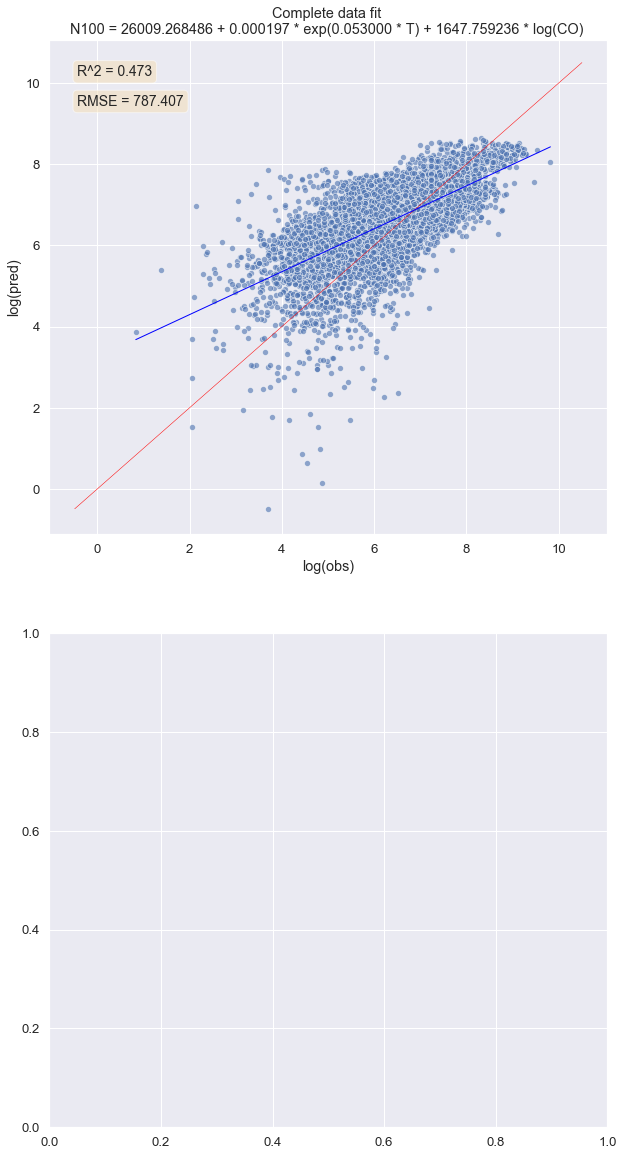

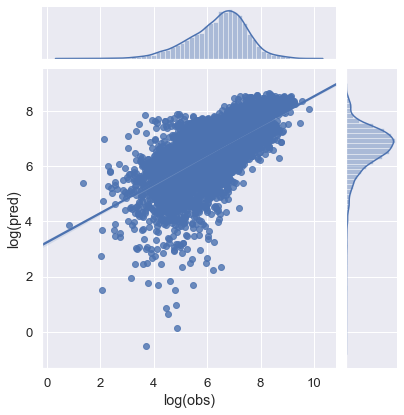

In [418]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10,20)
sns.set(font_scale=1.2)

cs = np.arange(0.001,0.2, 0.001)
best_c = 1
smallest_rmse = 100000

for c in cs:
    X, y = args_for_lm(data, c)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    lm, fit, pred = lin_model(X_train, y_train, X_test)
    rmse = np.sqrt(mean_squared_error(y_test,pred))

    if rmse < smallest_rmse:
        smallest_rmse = rmse
        best_c = c

# fit with the 'best' c

#lm, fit, pred = lin_model(X, y)
X, y = args_for_lm(data, best_c)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lm, fit, pred = lin_model(X_train, y_train, X_test)

coefs = np.insert(lm.coef_, 0, lm.intercept_)
coefs = np.insert(coefs, 2, best_c)
all_coefs[loc] = coefs

eq = equation(coefs)
rmse = np.sqrt(mean_squared_error(y_test,pred))
r2 = 'R^2 = ' + str(round(r2_score(y_test,pred), 3))
rmse_s = 'RMSE = ' + str(round(rmse, 3))


# for plotting get rid of < 0 values from predictions. Not many of these except for VAR which has 278
#pred[pred < 0] = np.mean(pred)

idx = pred > 0
y_test = y_test[idx]
pred = pred[idx]


# take logs for plotting 
y_test = np.log(y_test)
pred = np.log(pred)

d = pd.DataFrame({'log(obs)' : y_test, 'log(pred)' : pred})
draw_scatterplot_sns2(d, "Complete data", axs, 0, r2, rmse_s, eq)
sns.jointplot(x="log(obs)", y="log(pred)", data=d, kind="reg")

## Comparison of Värriö and Hohenpoissenberg variable distributions

This model fits better for Värriö than Hohenpoissenberg. Here are the variable distributions for both.

In [419]:
def draw_histograms(d1, d2, variable, loc1, loc2, title, xlim, b):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    
    ax1.hist(d1[variable], bins = b)
    ax1.set_xlim(xlim)
    ax1.set_title(loc1)
    
    
    ax2.hist(d2[variable], bins = b)
    ax2.set_xlim(xlim)
    ax2.set_title(loc2)
    
    fig.tight_layout()
    

/Users/privatejet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/privatejet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


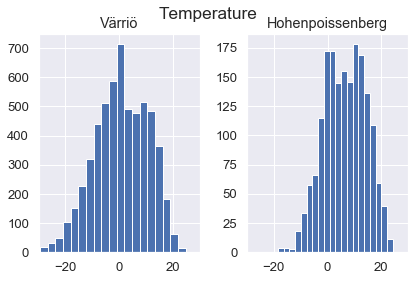

In [420]:
var = data[(data['city'] == 'VAR')] # 'good' fit, Värriö
hpb = data[(data['city'] == 'HPB')] # 'not as good' fit, Hohenpoissenberg
var['t'] = var['t'] - 273.15
hpb['t'] = hpb['t'] - 273.15

draw_histograms(var, hpb, 't', 'Värriö', 'Hohenpoissenberg', 'Temperature', [-30, 30], 20)


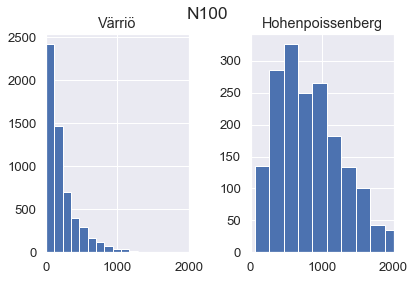

In [421]:
draw_histograms(var, hpb, 'concentration', 'Värriö', 'Hohenpoissenberg', 'N100', [0, 2000], 20)

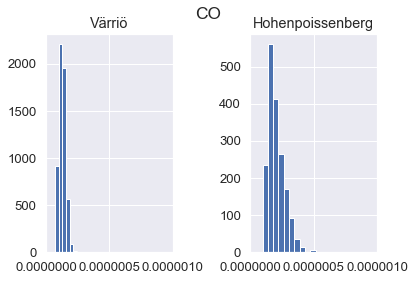

In [422]:
draw_histograms(var, hpb, 'co', 'Värriö', 'Hohenpoissenberg', 'CO', [0,1e-6], 10)

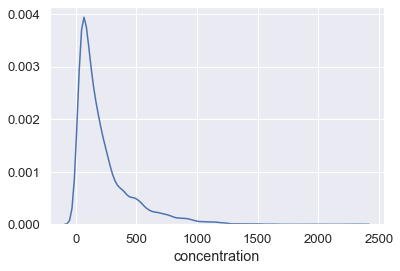

In [423]:
sns.distplot(var['concentration'], hist=False, rug=False);

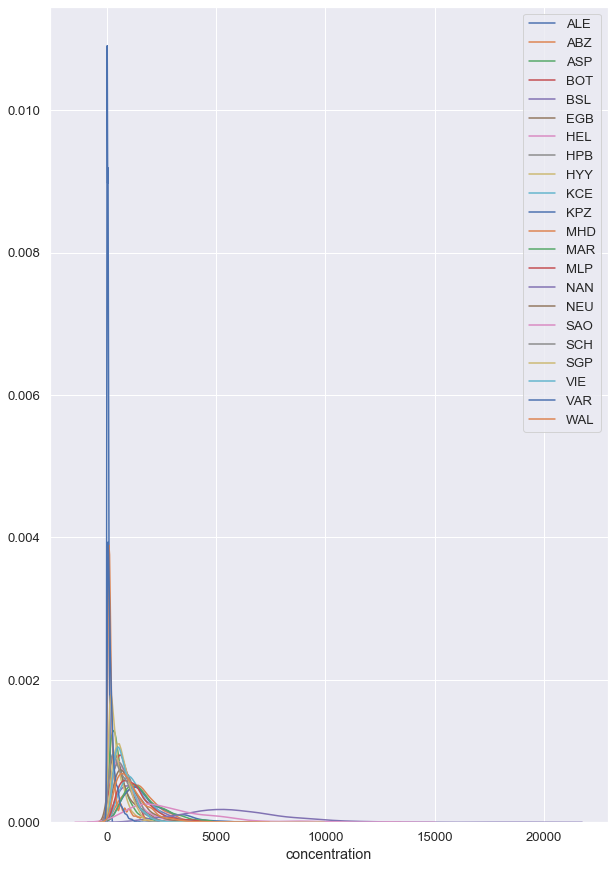

In [424]:
fig = plt.gcf()
fig.set_size_inches( 10, 15)

for i, loc in enumerate(cities):
    loc_data = data[data['city'] == loc]
    sns.distplot(loc_data['concentration'], hist=False, kde = True, label = loc, bins = 10);

In [350]:
all_coefs

{'ALE': array([ 2.95277029e+03,  1.67651899e+02,  1.00000000e-03, -1.63642186e+02]),
 'ABZ': array([2.91787720e+04, 1.80218371e+03, 1.02000000e-01, 8.10510309e-11]),
 'ASP': array([2.31614262e+04, 1.47665907e+03, 8.20000000e-02, 5.80535634e-08]),
 'BOT': array([9.47390533e+03, 5.85430087e+02, 6.60000000e-02, 1.59393314e-06]),
 'BSL': array([4.27279539e+04, 2.66880227e+03, 1.22000000e-01, 3.79233200e-13]),
 'EGB': array([1.68518451e+04, 1.07230791e+03, 7.50000000e-02, 1.94307243e-07]),
 'HEL': array([1.94195560e+04, 1.20017434e+03, 1.23000000e-01, 1.82203964e-13]),
 'HPB': array([9.85010072e+03, 5.98935749e+02, 1.22000000e-01, 2.82362720e-13]),
 'HYY': array([1.54370014e+04, 9.76778983e+02, 7.80000000e-02, 1.24544446e-07]),
 'KCE': array([2.85523485e+04, 1.76501132e+03, 1.21000000e-01, 1.92236523e-13]),
 'KPZ': array([4.83287277e+04, 3.00273506e+03, 1.19000000e-01, 1.51930884e-13]),
 'MHD': array([3.12573142e+04, 1.99791363e+03, 1.24000000e-01, 4.20179221e-13]),
 'MAR': array([1.4254076